# Task 5 - Advanced models

In this part, we will use XGboost as our classification model. 


### Imports

In [1]:
from ift6758.data.nhl_data_parser import NHLDataParser
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.metrics import  RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import wandb

import warnings
warnings.filterwarnings("ignore")

os.environ["WANDB_NOTEBOOK_NAME"] = "Task 5.ipynb"


### Data loading

In [2]:
# Load the data
data_parser = NHLDataParser()
train_df = data_parser.get_shot_and_goal_pbp_df_for_seasons(2016, 2018, with_playoff_season=False)
val_df = data_parser.get_shot_and_goal_pbp_df_for_season(2019, with_playoff_season=False)
test_df = data_parser.get_shot_and_goal_pbp_df_for_season(2020, with_playoff_season=False)

train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

In [47]:
# load path and make dirs to store model
model_path = os.getenv("MODEL_PATH")
XGB_path = os.path.join(model_path, "XGBoost")
if not os.path.exists(XGB_path):
    os.makedirs(XGB_path)

In [4]:
wandb.init(
    project="IFT6758.2024-B08", 
    entity="team08", 
    settings=wandb.Settings(init_timeout=120),
    config={
        "WANDB_NOTEBOOK_NAME": "Task 5.ipynb.ipynb",
        
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dalia-belaid (team08). Use `wandb login --relogin` to force relogin


### XGBoost 1: Distance feature only

AUC: 0.7226574829541836


AUC,▁
AUC,0.72266


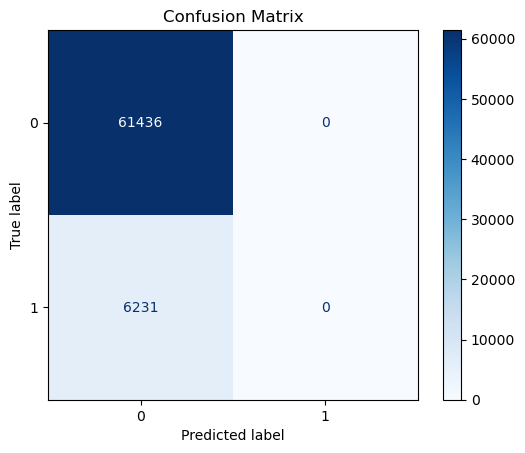

In [5]:
wandb.run.name = "XGB_Distance_Only"

X_train = train_df[['shotDistance']]
y_train = train_df['isGoal']

X_val = val_df[['shotDistance']]
y_val = val_df['isGoal']

XGB_1 = XGBClassifier()
XGB_1_log = XGB_1.fit(X_train, y_train)
prediction_1 = XGB_1.predict(X_val)
prob_scores_1 = XGB_1.predict_proba(X_val)[:, 1]
auc_1 = roc_auc_score(y_val, prob_scores_1)
print('AUC:', auc_1)
wandb.log({"AUC": auc_1})

cm_1 = confusion_matrix(y_val, prediction_1)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=XGB_1.classes_)
disp_1.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_1.png")
wandb.log({"Confusion Matrix": wandb.Image("confusion_matrix_1.png")})

model_1_path = os.path.join(XGB_path, "xgb_distance.pkl")
with open(model_1_path, 'wb') as f:
    pickle.dump(XGB_1_log, f)
wandb.finish()

### XGBoost 2: Angle feature only

AUC: 0.6084668170586196


AUC,▁
AUC,0.60847


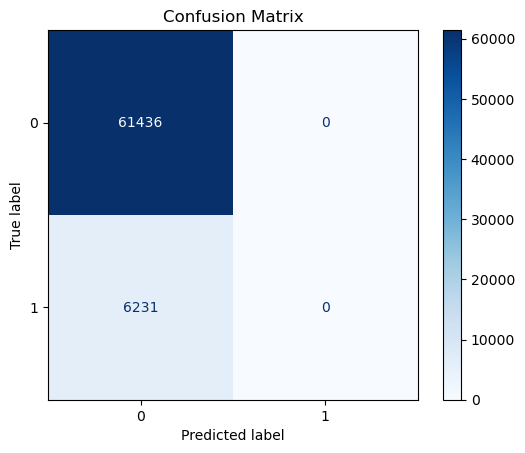

In [6]:
wandb.init(
    project="IFT6758.2024-B08", 
    entity="team08", 
    settings=wandb.Settings(init_timeout=120),
    config={
        "WANDB_NOTEBOOK_NAME": "Task 5.ipynb.ipynb",
        
    }
)

wandb.run.name = "XGB_Angle_Only"

X_train = train_df[['shotAngle']]
y_train = train_df['isGoal']

X_val = val_df[['shotAngle']]
y_val = val_df['isGoal']

XGB_2 = XGBClassifier()
XGB_2_log = XGB_2.fit(X_train, y_train)

prediction_2 = XGB_2.predict(X_val)
prob_scores_2 = XGB_2.predict_proba(X_val)[:,1]
auc_2 = roc_auc_score(y_val, prob_scores_2)

print('AUC:', auc_2)

wandb.log({"AUC": auc_2})
cm_2 = confusion_matrix(y_val, prediction_2)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=XGB_2.classes_)
disp_2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_2.png")
wandb.log({"Confusion Matrix": wandb.Image("confusion_matrix_2.png")})


model_2_path = os.path.join(XGB_path, "xgb_angle.pkl")
with open(model_2_path, 'wb') as f:
    pickle.dump(XGB_2_log, f)
wandb.finish()

### XGBoost 3: Angle and distance features

Accuracy: 0.9078871532652548
Precision: 0.48214285714285715
AUC: 0.7336206083683016


AUC,▁
AUC,0.73362


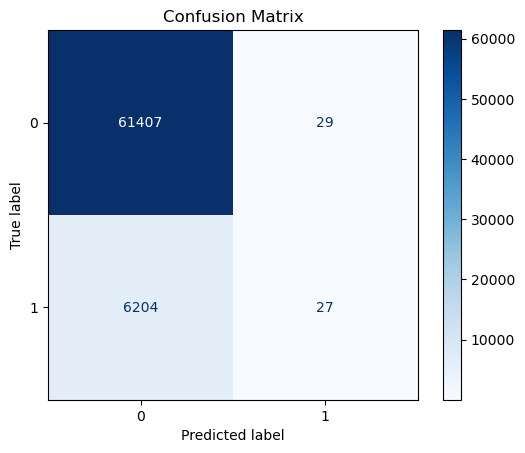

In [7]:
wandb.init(
    project="IFT6758.2024-B08", 
    entity="team08", 
    settings=wandb.Settings(init_timeout=120),
    config={
        "WANDB_NOTEBOOK_NAME": "Task 5.ipynb.ipynb",
        
    }
)
wandb.run.name = "XGB_Distance_Angle"

X_train = train_df[['shotAngle', 'shotDistance']]
y_train = train_df['isGoal']

X_val = val_df[['shotAngle', 'shotDistance']]
y_val = val_df['isGoal']

XGB_3 = XGBClassifier()
XGB_3_log = XGB_3.fit(X_train, y_train)
prediction_3 = XGB_3.predict(X_val)
prob_scores_3 = XGB_3.predict_proba(X_val)[:,1]

accuracy = accuracy_score(y_val, prediction_3)
precision = precision_score(y_val, prediction_3)
auc_3 = roc_auc_score(y_val, prob_scores_3)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('AUC:', auc_3)
wandb.log({"AUC": auc_3})

cm_3 = confusion_matrix(y_val, prediction_3)
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=XGB_3.classes_)
disp_3.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_3.png")
wandb.log({"Confusion Matrix": wandb.Image("confusion_matrix_3.png")})


prob_scores_3 = XGB_3.predict_proba(X_val)[:,1]
model_3_path = os.path.join(XGB_path, "xgb_angle_distance.pkl")
with open(model_3_path, 'wb') as f:
    pickle.dump(XGB_3_log, f)

wandb.finish()


### Graphs

In [8]:
#Collect all the probabilities
prob_scores = [('Distance',prob_scores_1), ('Angle',prob_scores_2), ('Angle and Distance',prob_scores_3)]

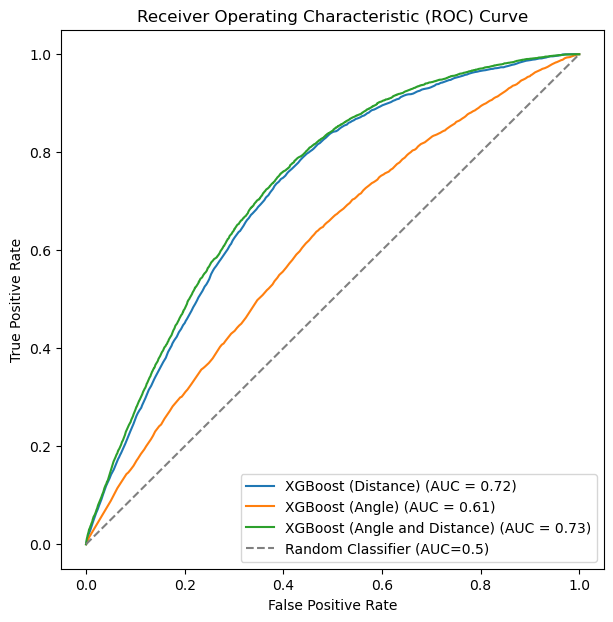

In [9]:
#Graph 1: Roc Curve

fig_1, ax_1 = plt.subplots()
roc = {}
plot_random = False

# Plot the ROC curve for each classifier
for name, prob_score in prob_scores:
    roc[name] = RocCurveDisplay.from_predictions(
        y_val,
        prob_score,
        ax=ax_1,
        name=f'XGBoost ({name})'
    )
    if name == 'Angle and Distance' and not plot_random:
        ax_1.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier (AUC=0.5)', color='gray')
        plot_random = True

ax_1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax_1.set_xlabel('False Positive Rate')
ax_1.set_ylabel('True Positive Rate')
ax_1.legend(loc='lower right')
fig_1.set_size_inches(7, 7)
plt.show()


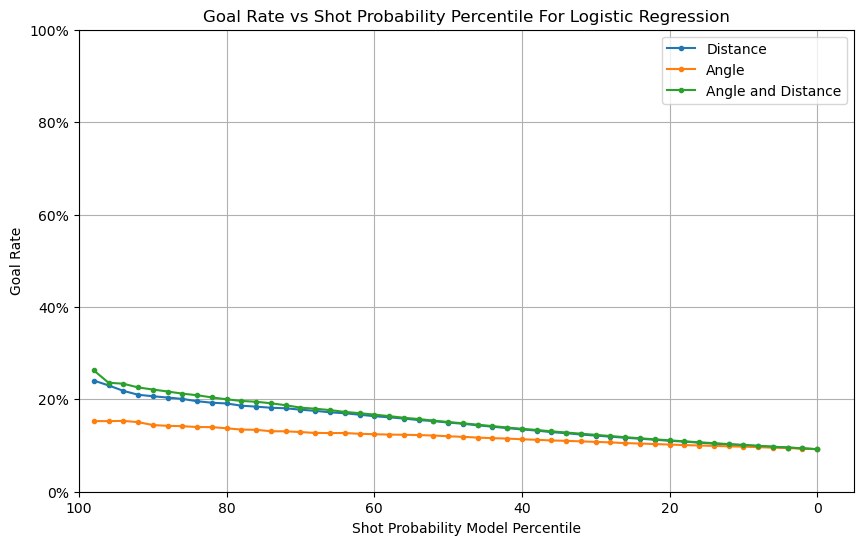

In [10]:
#Graph 2: Goal Rate as a Function of Shot Probability Model Percentile

# Calculate the percentiles for the shot probabilities for all models
percentile_bins = np.arange(0, 100, 2)
percentiles = {}
for name, prob_score in prob_scores:
    percentile_data = np.percentile(prob_score , percentile_bins)
    percentiles[name] = percentile_data


# Calculate the goal rates for each percentile for all models
goal_rates = {}
for name, prob_score in prob_scores:
    goal_rates[name] = []
    for percentile in percentiles[name]:
        mask = prob_score  >= percentile
        goal_rates[name].append(y_val[mask].mean())


# Plot the goal rate as a function of the shot probability model percentile for all models

fig_2, ax_2 = plt.subplots()
for name, goal_rate in goal_rates.items():
    ax_2.plot(percentile_bins, goal_rate, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Goal Rate')
plt.title('Goal Rate vs Shot Probability Percentile For Logistic Regression')
plt.grid(True)
plt.legend()
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, -5)
fig_2.set_size_inches(10,6)
plt.show()

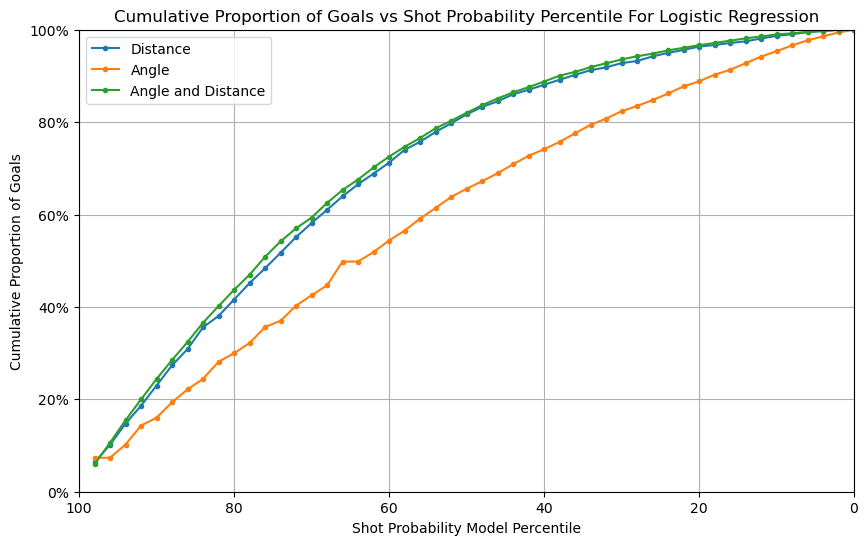

In [11]:
# Graph 3: Cumulative Proportion of Goals as a Function of Shot Probability Model Percentile 

# Calculate the cumulative goal percentage for each percentile for all models
cumulative_goal_proportions = {}
for name, prob_score in prob_scores:
    cumulative_goal_proportions[name] = []
    for percentile in percentiles[name]:
        mask = prob_score  >= percentile
        cumulative_goal_proportions[name].append(y_val[mask].sum() / y_val.sum())


# Plot the cumulative proportion of goals as a function of the shot probability model percentile for all models
fig_3, ax_3 = plt.subplots()
for name, cumulative_goal_proportion in cumulative_goal_proportions.items():
    ax_3.plot(percentile_bins, cumulative_goal_proportion, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Cumulative Proportion of Goals')
plt.title('Cumulative Proportion of Goals vs Shot Probability Percentile For Logistic Regression')
plt.grid(True)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, 0)
plt.legend()
fig_3.set_size_inches(10,6)
plt.show()

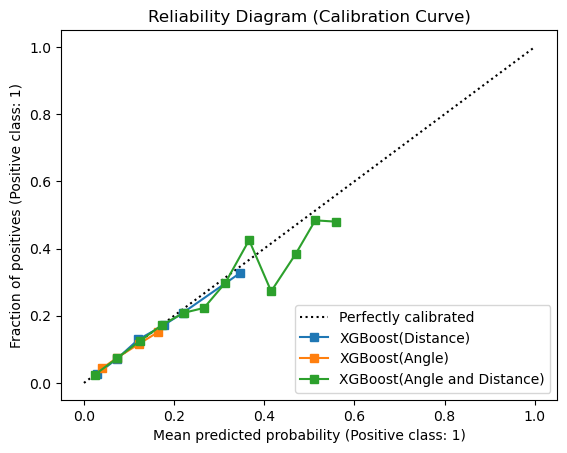

In [12]:
# Graph 4: Calibration Curve
fig_4,ax_4 = plt.subplots()
#Plot the calibration curve for each classifier
for name, prob_score in prob_scores:
    CalibrationDisplay.from_predictions(y_val, prob_score, n_bins=20, strategy='uniform',ax=ax_4,name=f'XGBoost({name})')
plt.title('Reliability Diagram (Calibration Curve)')
plt.show()

### XGBoost using the extracted features

In this section, we will use all the features exracted during the previous steps to train our model. Engineered features are:

Game related features
* Game seconds
* Game period
* Coordinates (x,y, separate columns)
* Shot distance
* Shot angle
* Shot type

Shot related features:
* Last event type
* Coordinates of the last event (x, y, separate columns)
* Time from the last event (seconds)
* Distance from the last event

State of the play features: 
* Rebound
* Change in shot angle
* Speed



In [13]:
train_df.dtypes

gameId                int64
timeRemaining         int64
periodNumber          int64
timeInPeriod         object
isGoal                int64
shotType             object
emptyNet              int64
xCoord              float64
yCoord              float64
zoneCode             object
shootingTeam         object
shotDistance        float64
shotAngle           float64
shootingTeamSide      int64
shootingPlayer       object
goalieInNet          object
previousEvent        object
timeDiff            float64
previousEventX      float64
previousEventY      float64
rebound               int64
distanceDiff        float64
shotAngleDiff       float64
speed               float64
dtype: object

Some of the extracted variables are non numerical, we will encode them to enable the model training using these variables.


In [14]:
# Label encode categorical features (previousEvent, shotType)
def Encoder (df: pd.DataFrame): 
    label_encoder_shotType = LabelEncoder()
    label_encoder_previousEvent = LabelEncoder()    
    df['shotType'] = label_encoder_shotType.fit_transform(df['shotType'])
    df['previousEvent   '] = label_encoder_previousEvent.fit_transform(df['previousEvent'])

In [15]:
train_df['shotType'].value_counts()

wrist          120039
slap            36076
snap            33689
backhand        18186
tip-in          11467
deflected        3593
wrap-around      2313
Name: shotType, dtype: int64

In [16]:
Encoder(train_df)
Encoder(val_df)

In [17]:
X_train = train_df[['periodNumber','timeRemaining','shotAngle', 'shotDistance','shotType' ,'xCoord', 'yCoord', 'previousEventX', 'previousEventY', 'rebound', 'timeDiff', 
                    'distanceDiff', 'shotAngleDiff', 'speed']]
y_train = train_df['isGoal']

X_val = val_df[['periodNumber','timeRemaining','shotAngle', 'shotDistance','shotType' ,'xCoord', 'yCoord', 'previousEventX', 'previousEventY', 'rebound', 'timeDiff', 
                'distanceDiff', 'shotAngleDiff', 'speed']]
y_val = val_df['isGoal']

XGB_4 = XGBClassifier()

XGB_4_log = XGB_4.fit(X_train, y_train)

prediction_4 = XGB_4.predict(X_val)
prob_scores_4 = XGB_4.predict_proba(X_val)[:,1]
accuracy = accuracy_score(y_val, prediction_4)
precision = precision_score(y_val, prediction_4)
auc = roc_auc_score(y_val, prob_scores_4)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('AUC:', auc)

model_4_path = os.path.join(XGB_path, "xgb_AllFeatures.pkl")
with open(model_4_path, 'wb') as f:
    pickle.dump(XGB_4_log, f)

Accuracy: 0.9063354367712474
Precision: 0.41243862520458263
AUC: 0.7566992366998162


#### Hyperparameter tuning

We will perform hyperparameter tuning using gridsearch

Grid Search

In [18]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 1, 5],
}

XGB_GridSearch = XGBClassifier()

# Perform grid search
grid_search = GridSearchCV(
    estimator=XGB_GridSearch,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'gamma': 5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [19]:
wandb.init(
    project="IFT6758.2024-B08", 
    entity="team08", 
    settings=wandb.Settings(init_timeout=120),
    config={
        "WANDB_NOTEBOOK_NAME": "Task 5.ipynb.ipynb",
        
    }
)
wandb.run.name = "XGB_Finetuning"

X_train = train_df[['periodNumber','timeRemaining','shotAngle', 'shotDistance','shotType' ,'xCoord', 'yCoord', 'previousEventX', 'previousEventY', 'rebound', 'timeDiff', 
                    'distanceDiff', 'shotAngleDiff', 'speed']]
y_train = train_df['isGoal']

X_val = val_df[['periodNumber','timeRemaining','shotAngle', 'shotDistance','shotType' ,'xCoord', 'yCoord', 'previousEventX', 'previousEventY', 'rebound', 'timeDiff', 
                'distanceDiff', 'shotAngleDiff', 'speed']]
y_val = val_df['isGoal']

XGB_5 = XGBClassifier(n_estimators= 100, learning_rate= 0.1, max_depth= 7, gamma= 5, random_state= 42)

XGB_5_log = XGB_5.fit(X_train, y_train)

prediction_5 = XGB_5.predict(X_val)
prob_scores_5 = XGB_5.predict_proba(X_val)[:,1]
auc_5 = roc_auc_score(y_val, prob_scores_2)

print('AUC:', auc_5)

wandb.log({"AUC": auc_5})

model_5_path = os.path.join(XGB_path, "xgb_AllFeatures_GridSearch.pkl")
with open(model_5_path, 'wb') as f:
    pickle.dump(XGB_5_log, f)
wandb.finish()

AUC: 0.6084668170586196


AUC,▁
AUC,0.60847


Bayesian optimization

In [20]:
import random
import optuna
def Bayesian_Search(trial):
    random.seed(42)
    np.random.seed(42)
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'gamma': trial.suggest_int('gamma', 0, 5, 2)
    }
    
    model = XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric='auc')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(Bayesian_Search, n_trials=50)
print("Best Parameters:", study.best_params)

[I 2024-11-22 20:22:43,821] A new study created in memory with name: no-name-b6b2bbf0-d4da-44f4-a249-5280dee1c068


Best Parameters: {'n_estimators': 191, 'max_depth': 10, 'learning_rate': 0.19994762013708026, 'gamma': 0}


In [21]:
X_train = train_df[['periodNumber','timeRemaining','shotAngle', 'shotDistance','shotType' ,'xCoord', 'yCoord', 'previousEventX', 'previousEventY', 'rebound', 'timeDiff', 
                    'distanceDiff', 'shotAngleDiff', 'speed']]
y_train = train_df['isGoal']

X_val = val_df[['periodNumber','timeRemaining','shotAngle', 'shotDistance','shotType' ,'xCoord', 'yCoord', 'previousEventX', 'previousEventY', 'rebound', 'timeDiff', 
                'distanceDiff', 'shotAngleDiff', 'speed']]
y_val = val_df['isGoal']

XGB_6 = XGBClassifier(n_estimators= 188, learning_rate= 0.2, max_depth= 9, gamma= 0, random_state= 42)

XGB_6_log = XGB_6.fit(X_train, y_train)

prediction_6 = XGB_6.predict(X_val)
prob_scores_6 = XGB_6.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, prob_scores_6)
print('AUC:', auc)
model_6_path = os.path.join(XGB_path, "xgb_AllFeatures_GridSearch.pkl")
with open(model_6_path, 'wb') as f:
    pickle.dump(XGB_6_log, f)

AUC: 0.7435473623002938


In [22]:
prob_scores = [('Distance',prob_scores_1), ('Angle',prob_scores_2), ('Angle and Distance',prob_scores_3), 
('All features with Grid Search', prob_scores_5)]

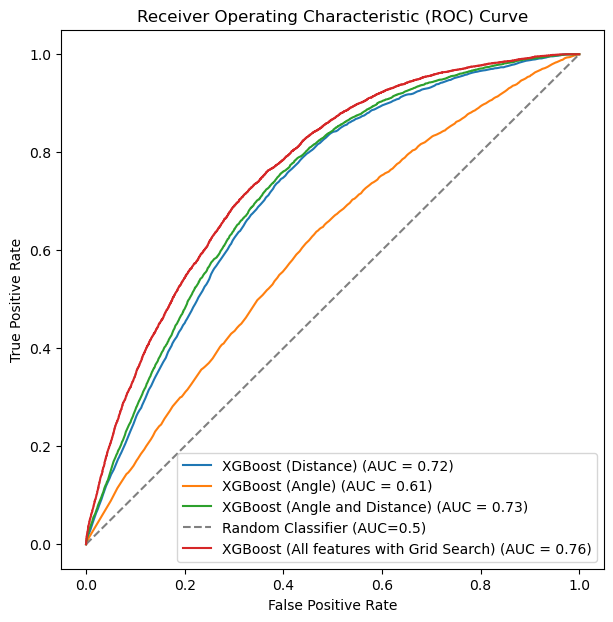

In [23]:
fig_1, ax_1 = plt.subplots()
roc = {}
plot_random = False

# Plot the ROC curve for each classifier
for name, prob_score in prob_scores:
    roc[name] = RocCurveDisplay.from_predictions(
        y_val,
        prob_score,
        ax=ax_1,
        name=f'XGBoost ({name})'
    )
    if name == 'Angle and Distance' and not plot_random:
        ax_1.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier (AUC=0.5)', color='gray')
        plot_random = True

ax_1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax_1.set_xlabel('False Positive Rate')
ax_1.set_ylabel('True Positive Rate')
ax_1.legend(loc='lower right')
fig_1.set_size_inches(7, 7)
plt.show()

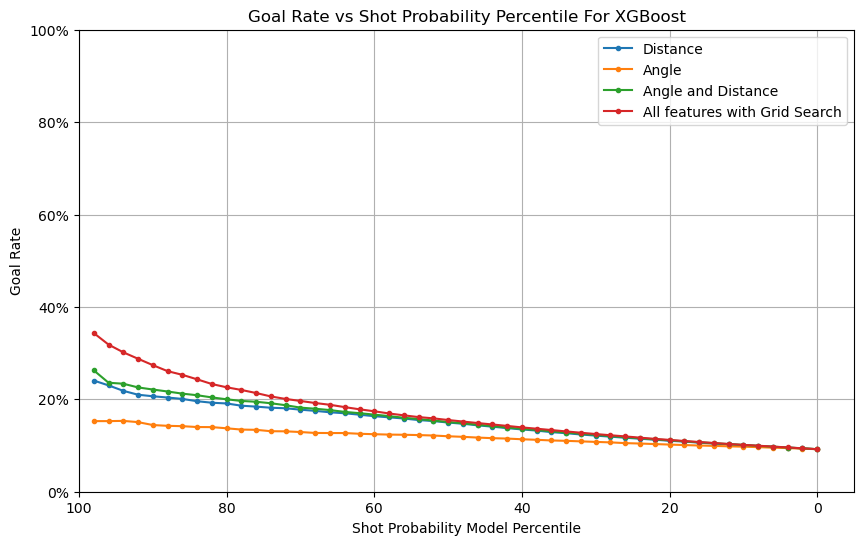

In [24]:
#Graph 2: Goal Rate as a Function of Shot Probability Model Percentile

# Calculate the percentiles for the shot probabilities for all models
percentile_bins = np.arange(0, 100, 2)
percentiles = {}
for name, prob_score in prob_scores:
    percentile_data = np.percentile(prob_score , percentile_bins)
    percentiles[name] = percentile_data


# Calculate the goal rates for each percentile for all models
goal_rates = {}
for name, prob_score in prob_scores:
    goal_rates[name] = []
    for percentile in percentiles[name]:
        mask = prob_score  >= percentile
        goal_rates[name].append(y_val[mask].mean())


# Plot the goal rate as a function of the shot probability model percentile for all models

fig_2, ax_2 = plt.subplots()
for name, goal_rate in goal_rates.items():
    ax_2.plot(percentile_bins, goal_rate, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Goal Rate')
plt.title('Goal Rate vs Shot Probability Percentile For XGBoost')
plt.grid(True)
plt.legend()
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, -5)
fig_2.set_size_inches(10,6)
plt.show()



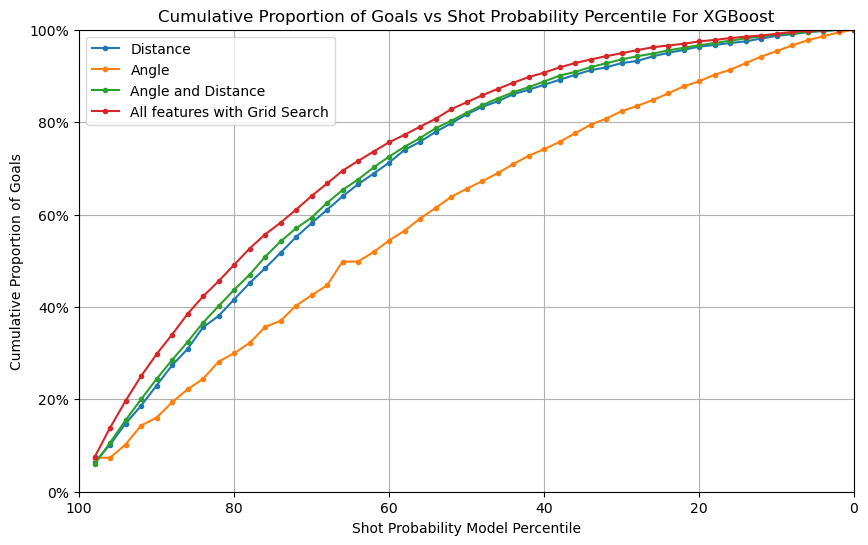

In [25]:
# Graph 3: Cumulative Proportion of Goals as a Function of Shot Probability Model Percentile 

# Calculate the cumulative goal percentage for each percentile for all models
cumulative_goal_proportions = {}
for name, prob_score in prob_scores:
    cumulative_goal_proportions[name] = []
    for percentile in percentiles[name]:
        mask = prob_score  >= percentile
        cumulative_goal_proportions[name].append(y_val[mask].sum() / y_val.sum())


# Plot the cumulative proportion of goals as a function of the shot probability model percentile for all models
fig_3, ax_3 = plt.subplots()
for name, cumulative_goal_proportion in cumulative_goal_proportions.items():
    ax_3.plot(percentile_bins, cumulative_goal_proportion, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Cumulative Proportion of Goals')
plt.title('Cumulative Proportion of Goals vs Shot Probability Percentile For XGBoost')
plt.grid(True)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, 0)
plt.legend()
fig_3.set_size_inches(10,6)
plt.show()

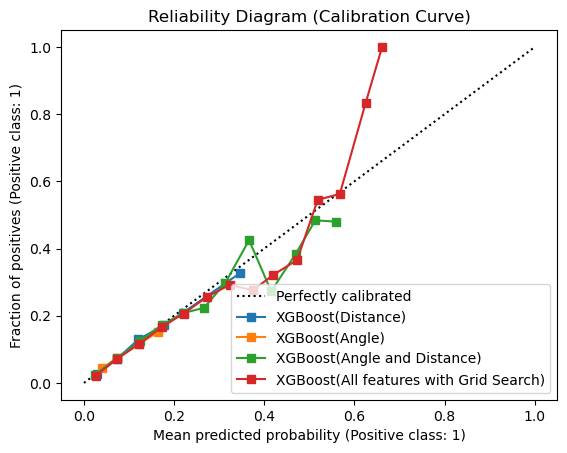

In [26]:
# Graph 4: Calibration Curve
fig_4,ax_4 = plt.subplots()
#Plot the calibration curve for each classifier
for name, prob_score in prob_scores:
    CalibrationDisplay.from_predictions(y_val, prob_score, n_bins=20, strategy='uniform',ax=ax_4,name=f'XGBoost({name})')
plt.title('Reliability Diagram (Calibration Curve)')
plt.show()

#### Feature selection & Feature importance

In [27]:
XGB_model = XGB_5

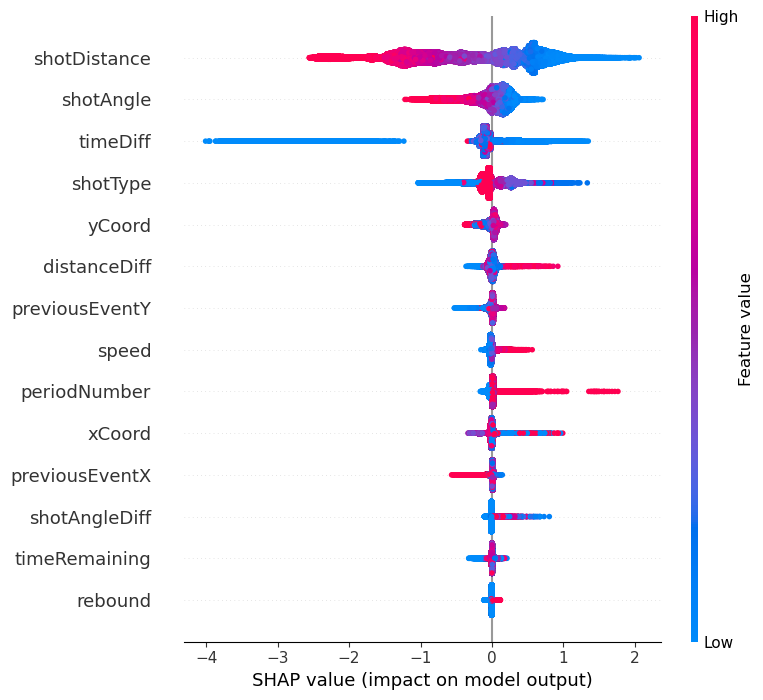

In [28]:
import shap

XGB_model.fit(X_train, y_train)

explainer = shap.TreeExplainer(XGB_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [29]:
X_train_shap = X_train.drop(columns=['rebound', 'timeRemaining'], axis=1)
X_val_shap = X_val.drop(columns=['rebound', 'timeRemaining'], axis=1)

xgb_5_shap = XGB_model
xgb_5_shap.fit(X_train_shap, y_train)
y_pred_shap = xgb_5_shap.predict(X_val_shap)
prob_scores_shap = xgb_5_shap.predict_proba(X_val_shap)[:,1]
auc = roc_auc_score(y_val, prob_scores_shap)
print('AUC:', auc)

AUC: 0.7626754759561848


##### Correlation 

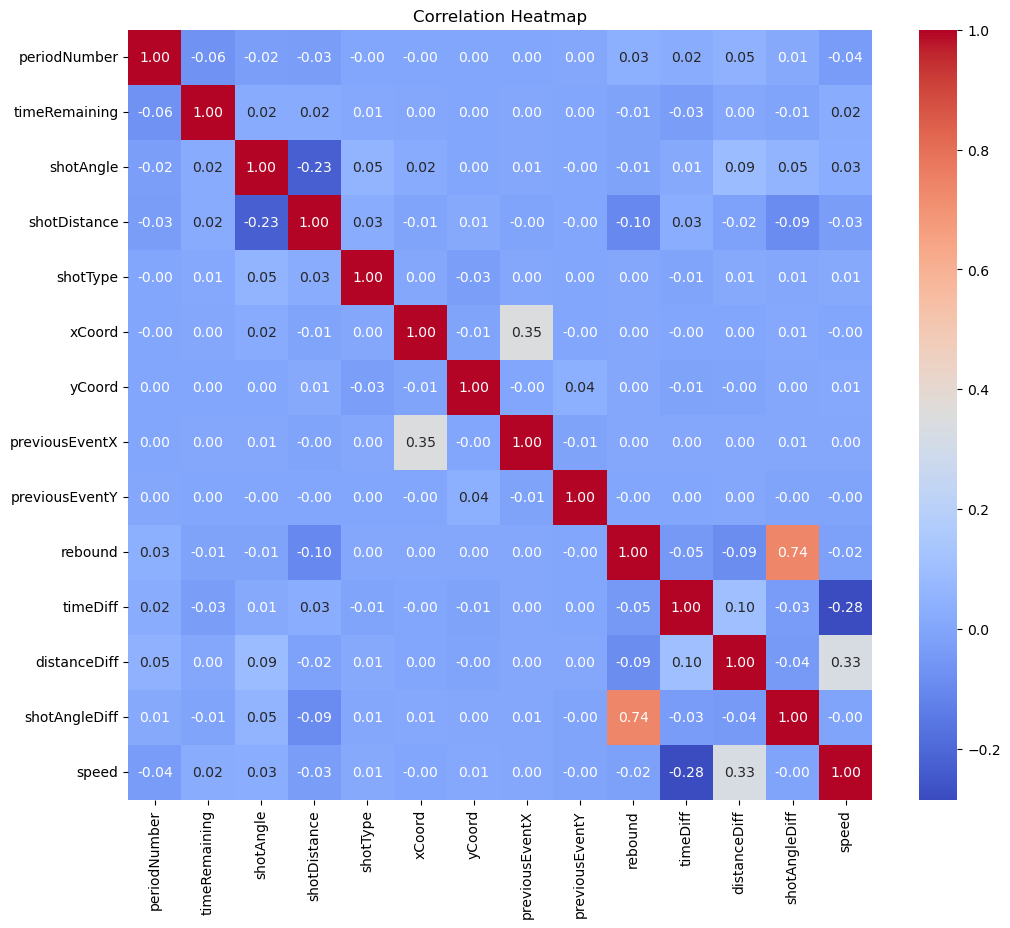

In [30]:
import seaborn as sns
correlation_matrix = X_train.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

Based on the heatmap "rebound" and "shotAngleDiff" are highly correlated, we should consider only one of them in the final feature set. 

In [31]:
X_train_heatmap = X_train.drop(columns='rebound', axis=1)
X_val_heatmap = X_val.drop(columns='rebound', axis=1)

xgb_5_heatmap = XGB_model
xgb_5_heatmap.fit(X_train_heatmap, y_train)
y_pred_heatmap = xgb_5_heatmap.predict(X_val_heatmap)
prob_scores_heatmap = xgb_5_heatmap.predict_proba(X_val_heatmap)[:,1]
auc = roc_auc_score(y_val, prob_scores_heatmap)
print('AUC:', auc)


AUC: 0.7625189326121107


##### Recursive Feature Elimination (RFE)

In [32]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=XGB_model, n_features_to_select=13)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

X_train_rfe = rfe.transform(X_train)
X_val_rfe = rfe.transform(X_val)

xgb_5_rfe = XGB_model
xgb_5_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = xgb_5_rfe.predict(X_val_rfe)

prob_score_rfe = xgb_5_rfe.predict_proba(X_val_rfe)[:,1]
auc = roc_auc_score(y_val, prob_score_rfe)
print('AUC:', auc)

Selected Features: Index(['periodNumber', 'shotAngle', 'shotDistance', 'shotType', 'xCoord',
       'yCoord', 'previousEventX', 'previousEventY', 'rebound', 'timeDiff',
       'distanceDiff', 'shotAngleDiff', 'speed'],
      dtype='object')
AUC: 0.7633455956775961


##### Sequential Feature Selection (SFS)

In [33]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(
    estimator=XGB_model,
    n_features_to_select=13,
    direction='forward',
    cv=5
)
sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print("Selected Features:", selected_features)

X_train_sfs = X_train[selected_features]
X_val_sfs = X_val[selected_features]

xgb_5_sfs = XGB_model
xgb_5_sfs.fit(X_train_sfs, y_train)
y_pred_sfs = xgb_5_sfs.predict(X_val_sfs)

prob_score_sfs = xgb_5_sfs.predict_proba(X_val_sfs)[:,1]
auc = roc_auc_score(y_val, prob_score_sfs)
print('AUC:', auc)


Selected Features: Index(['periodNumber', 'timeRemaining', 'shotAngle', 'shotDistance',
       'shotType', 'xCoord', 'yCoord', 'previousEventX', 'previousEventY',
       'rebound', 'timeDiff', 'distanceDiff', 'shotAngleDiff'],
      dtype='object')
AUC: 0.7623201709445168


In [34]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(
    estimator=XGB_model,
    n_features_to_select=13,
    direction='backward',
    cv=5
)
sfs.fit(X_train, y_train)

selected_features = X_train.columns[sfs.get_support()]
print("Selected Features:", selected_features)

X_train_sfsb = X_train[selected_features]
X_val_sfsb = X_val[selected_features]

xgb_5_sfsb = XGB_model
xgb_5_sfsb.fit(X_train_sfsb, y_train)
y_pred_sfsb = xgb_5_sfsb.predict(X_val_sfsb)

prob_score_sfsb = xgb_5_sfs.predict_proba(X_val_sfsb)[:,1]
auc = roc_auc_score(y_val, prob_score_sfsb)
print('AUC:', auc)


Selected Features: Index(['periodNumber', 'timeRemaining', 'shotDistance', 'shotType', 'xCoord',
       'yCoord', 'previousEventX', 'previousEventY', 'rebound', 'timeDiff',
       'distanceDiff', 'shotAngleDiff', 'speed'],
      dtype='object')
AUC: 0.7632956619923513


##### Low variance 

In [35]:
VarianceThresh = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_train_transf = VarianceThresh.fit_transform(X_train)
print(X_train.shape)
print(X_train_transf.shape)

selected_features = VarianceThresh.get_support()
selected_feature_names = X_train.columns[selected_features]
print(selected_feature_names)

(225363, 14)
(225363, 13)
Index(['periodNumber', 'timeRemaining', 'shotAngle', 'shotDistance',
       'shotType', 'xCoord', 'yCoord', 'previousEventX', 'previousEventY',
       'timeDiff', 'distanceDiff', 'shotAngleDiff', 'speed'],
      dtype='object')


In [36]:
X_train_selected = X_train[selected_feature_names]
X_val_selected = X_val[selected_feature_names]

xgb_model_selected = XGB_model
xgb_model_selected.fit(X_train_selected, y_train)

y_pred_selected = xgb_model_selected.predict(X_val_selected)

prob_score_selected = xgb_model_selected.predict_proba(X_val_selected)[:,1]
auc = roc_auc_score(y_val, prob_score_selected)
print('AUC:', auc)

AUC: 0.7625189326121107


##### SelectKBest

In [37]:
train_df_KBest = train_df.dropna()
val_df_KBest = val_df.dropna()

X_train_KBest = train_df_KBest[['periodNumber','timeRemaining','shotAngle', 'shotDistance','shotType' ,'xCoord', 'yCoord', 'previousEventX', 'previousEventY', 'rebound', 'timeDiff', 
                    'distanceDiff', 'shotAngleDiff', 'speed']]
y_train_KBest = train_df_KBest['isGoal']

X_val_KBest = val_df_KBest[['periodNumber','timeRemaining','shotAngle', 'shotDistance','shotType' ,'xCoord', 'yCoord', 'previousEventX', 'previousEventY', 'rebound', 'timeDiff', 
                'distanceDiff', 'shotAngleDiff', 'speed']]
y_val_KBest = val_df_KBest['isGoal']

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(score_func=f_classif, k=13)
X_train_selected = selector.fit_transform(X_train_KBest, y_train_KBest)
X_val_selected = selector.transform(X_val_KBest)

selected_features = X_train_KBest.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['periodNumber', 'timeRemaining', 'shotAngle', 'shotDistance',
       'shotType', 'xCoord', 'yCoord', 'previousEventY', 'rebound', 'timeDiff',
       'distanceDiff', 'shotAngleDiff', 'speed'],
      dtype='object')


In [39]:
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

xgb_model_selected = XGB_model
xgb_model_selected.fit(X_train_selected, y_train)

y_pred_selected = xgb_model_selected.predict(X_val_selected)

prob_score_selected = xgb_model_selected.predict_proba(X_val_selected)[:,1]
auc = roc_auc_score(y_val, prob_score_selected)
print('AUC:', auc)

AUC: 0.7631939007206427


##### Final choice & Graphs

The feature selection technique that lended the best results is SFS with forward search. The final set of features selected is:

* periodNumber
* shotAngle
* shotDistance
* shotType
* xCoord
* yCoord
* previousEventX
* previousEventY
* speed
* timeDiff
* distanceDiff
* shotAngleDiff
* rebound

In [60]:
wandb.init(
    project="IFT6758.2024-B08", 
    entity="team08", 
    settings=wandb.Settings(init_timeout=120),
    config={
        "WANDB_NOTEBOOK_NAME": "Task 5.ipynb.ipynb",
        
    }
)
wandb.run.name = "XGB_Final"

selected_features= ['periodNumber', 'shotAngle', 'shotDistance', 'shotType', 'xCoord',
       'yCoord', 'previousEventX', 'previousEventY', 'rebound', 'timeDiff',
       'distanceDiff', 'shotAngleDiff', 'speed']
X_train_Final = X_train[selected_features]
X_val_Final = X_val[selected_features]

XGB_Final = XGBClassifier(max_depth=7, n_estimators= 100, gamma= 5, learning_rate= 0.1)

XGB_Final_log = XGB_Final.fit(X_train_Final, y_train)

prediction_Final = XGB_Final.predict(X_val_Final)
prob_scores_Final = XGB_Final.predict_proba(X_val_Final)[:,1]
auc_final = roc_auc_score(y_val, prob_scores_Final)

print('AUC:', auc_final)

wandb.log({"AUC": auc_final})
print('AUC:', auc)
model_Final_path = os.path.join(XGB_path, "xgb_Final.pkl")
with open(model_Final_path, 'wb') as f:
    pickle.dump(XGB_Final_log, f)
wandb.finish()

AUC: 0.7633455956775961
AUC: 0.7631939007206427


AUC,▁
AUC,0.76335


#### Log to wandb

In [61]:
from ift6758.data.data_logger import DataLogger
api_key = os.getenv("WANDB_API_KEY")
logger = DataLogger(project_name="IFT6758.2024-B08",entity='team08',group = 'XGBoost',API_KEY=api_key)
logger.log_models([(model_Final_path, 'xgb_Final')])


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Mega-PC\_netrc


In [41]:
prob_scores = [('Distance',prob_scores_1), ('Angle',prob_scores_2), ('Angle and Distance',prob_scores_3), 
('All features', prob_scores_Final)]

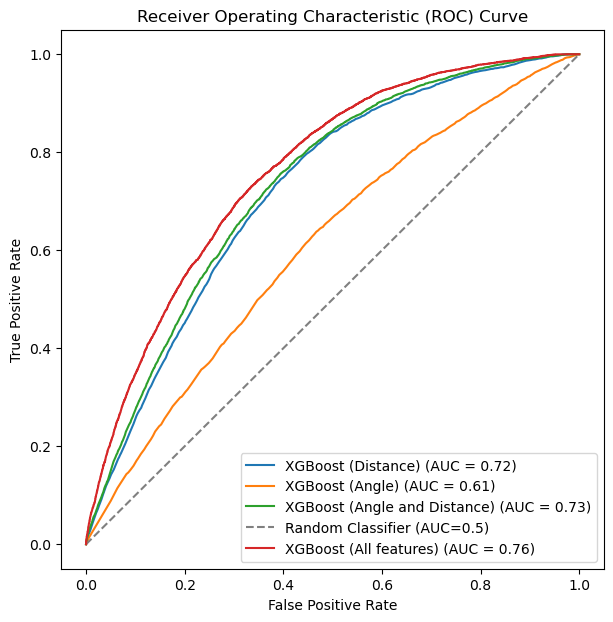

In [42]:
fig_1, ax_1 = plt.subplots()
roc = {}
plot_random = False

# Plot the ROC curve for each classifier
for name, prob_score in prob_scores:
    roc[name] = RocCurveDisplay.from_predictions(
        y_val,
        prob_score,
        ax=ax_1,
        name=f'XGBoost ({name})'
    )
    if name == 'Angle and Distance' and not plot_random:
        ax_1.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier (AUC=0.5)', color='gray')
        plot_random = True

ax_1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax_1.set_xlabel('False Positive Rate')
ax_1.set_ylabel('True Positive Rate')
ax_1.legend(loc='lower right')
fig_1.set_size_inches(7, 7)
plt.show()

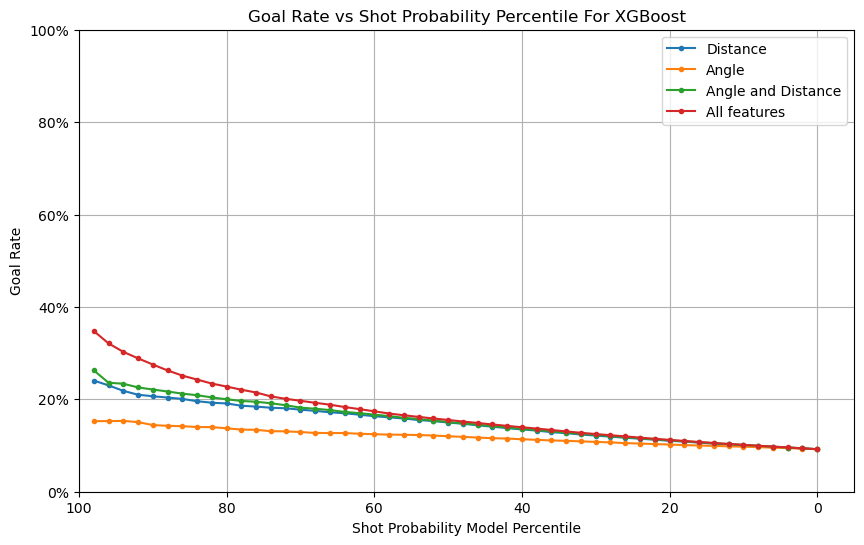

In [43]:
#Graph 2: Goal Rate as a Function of Shot Probability Model Percentile

# Calculate the percentiles for the shot probabilities for all models
percentile_bins = np.arange(0, 100, 2)
percentiles = {}
for name, prob_score in prob_scores:
    percentile_data = np.percentile(prob_score , percentile_bins)
    percentiles[name] = percentile_data


# Calculate the goal rates for each percentile for all models
goal_rates = {}
for name, prob_score in prob_scores:
    goal_rates[name] = []
    for percentile in percentiles[name]:
        mask = prob_score  >= percentile
        goal_rates[name].append(y_val[mask].mean())


# Plot the goal rate as a function of the shot probability model percentile for all models

fig_2, ax_2 = plt.subplots()
for name, goal_rate in goal_rates.items():
    ax_2.plot(percentile_bins, goal_rate, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Goal Rate')
plt.title('Goal Rate vs Shot Probability Percentile For XGBoost')
plt.grid(True)
plt.legend()
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, -5)
fig_2.set_size_inches(10,6)
plt.show()



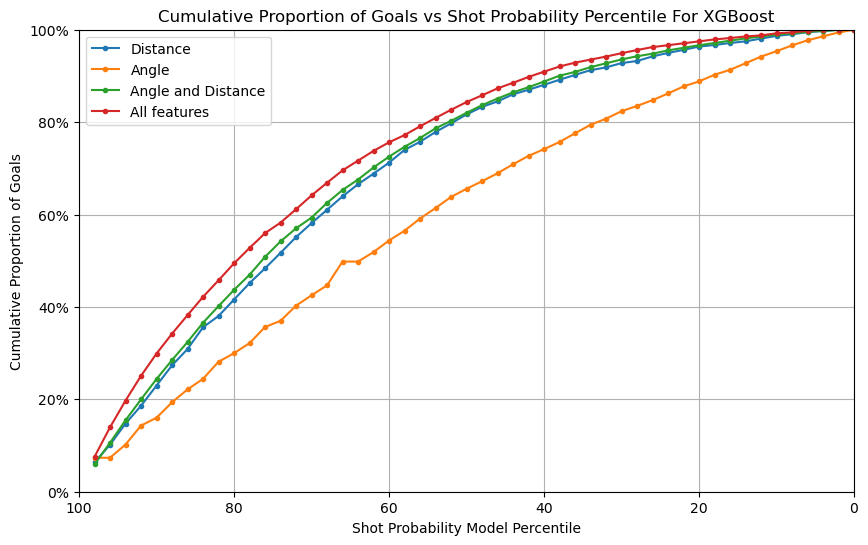

In [44]:
# Graph 3: Cumulative Proportion of Goals as a Function of Shot Probability Model Percentile 

# Calculate the cumulative goal percentage for each percentile for all models
cumulative_goal_proportions = {}
for name, prob_score in prob_scores:
    cumulative_goal_proportions[name] = []
    for percentile in percentiles[name]:
        mask = prob_score  >= percentile
        cumulative_goal_proportions[name].append(y_val[mask].sum() / y_val.sum())


# Plot the cumulative proportion of goals as a function of the shot probability model percentile for all models
fig_3, ax_3 = plt.subplots()
for name, cumulative_goal_proportion in cumulative_goal_proportions.items():
    ax_3.plot(percentile_bins, cumulative_goal_proportion, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Cumulative Proportion of Goals')
plt.title('Cumulative Proportion of Goals vs Shot Probability Percentile For XGBoost')
plt.grid(True)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, 0)
plt.legend()
fig_3.set_size_inches(10,6)
plt.show()

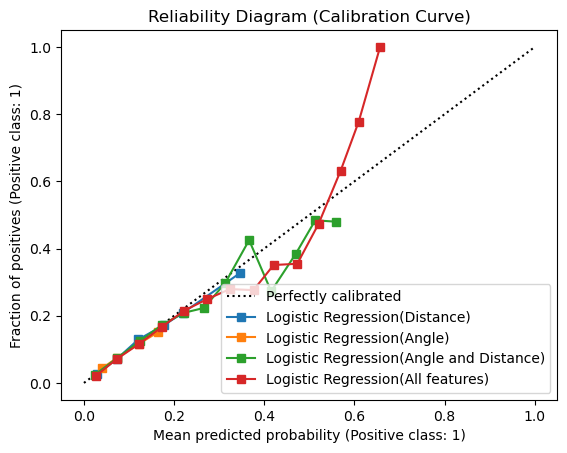

In [45]:
# Graph 4: Calibration Curve
fig_4,ax_4 = plt.subplots()
#Plot the calibration curve for each classifier
for name, prob_score in prob_scores:
    CalibrationDisplay.from_predictions(y_val, prob_score, n_bins=20, strategy='uniform',ax=ax_4,name=f'Logistic Regression({name})')
plt.title('Reliability Diagram (Calibration Curve)')
plt.show()

In [46]:
! pip install wandb